# Intro

## Premise
The issue is always the same: is everything we are doing correct?  
The fact that there is a non trivial superposition between Witten's review and all our documents is suspect...

## Standard modules

In [2]:
import os, sys
import pathlib
import requests

In [3]:
import numpy as np

In [4]:
from tqdm.auto import tqdm, trange

In [5]:
from sentence_transformers import util

In [6]:
import matplotlib.pyplot as plt
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.major.width'] = 2

plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['ytick.minor.width'] = 1

In [46]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.preprocessing import RobustScaler

In [8]:
import seaborn

In [9]:
import pymannkendall as mk

## Personal modules

In [10]:
from toolbox.updater import time_is_now

In [11]:
from file2text import file2text

In [12]:
from first_rough_cleaning import first_text_cleaner

In [13]:
from file_handler import *

In [14]:
from jina4lote import jina4lote

/home/sarawalk/sdgs_py38/lib/python3.8/site-packages/torch/cuda/__init__.py:118: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10020). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


## Folders

In [15]:
VECTOR_FOLDER='./NewProcessedData/vectors/'

In [16]:
BENCHMARK_FOLDER='./NewProcessedData/benchmarks/'

In [17]:
PCA_CENTR_VECTOR_FOLDER='./NewProcessedData/pca_centr_vectors/'

In [18]:
WIKI_FOLDER='./NewProcessedData/wikipedia/vectors/'

## Reports' vectors

In [19]:
vecfiles=os.listdir(VECTOR_FOLDER)

In [20]:
vecfiles.sort()

In [21]:
# files from 2024 are un reliable, 
# as they probably refer to a different accounting year,
# due to differences with other countries
len(vecfiles)

575

In [22]:
vecfiles=[vecfile for vecfile in vecfiles if not vecfile.startswith('2024')]

In [23]:
len(vecfiles)

573

## Witten's vector

In [24]:
wittenvecfile=[file for file in os.listdir(BENCHMARK_FOLDER) if file.startswith('Witten') and file.endswith('.txt')][0]

In [25]:
wittenvec=np.genfromtxt(BENCHMARK_FOLDER+wittenvecfile)

# Mean vector

In [26]:
for i, vecfile in enumerate(tqdm(vecfiles)):
    if i==0:
        mean_vec=np.genfromtxt(VECTOR_FOLDER+vecfile)
    else:
        mean_vec+=np.genfromtxt(VECTOR_FOLDER+vecfile)
mean_vec/=len(vecfiles)

  0%|          | 0/573 [00:00<?, ?it/s]

# Witten is quite close to be mean

 Witten is quite close to be mean

In [27]:
util.cos_sim(wittenvec, mean_vec)

tensor([[0.8199]], dtype=torch.float64)

...which is nice!

In [28]:
cos_sims=np.zeros(len(vecfiles))
for i, vecfile in enumerate(tqdm(vecfiles)):
    vec=np.genfromtxt(VECTOR_FOLDER+vecfile)
    cos_sim=float(util.cos_sim(wittenvec, vec-mean_vec))
    #print(f'{vecfile:})\tcos={cos_sim:.3f}')
    cos_sims[i]=cos_sim

  0%|          | 0/573 [00:00<?, ?it/s]

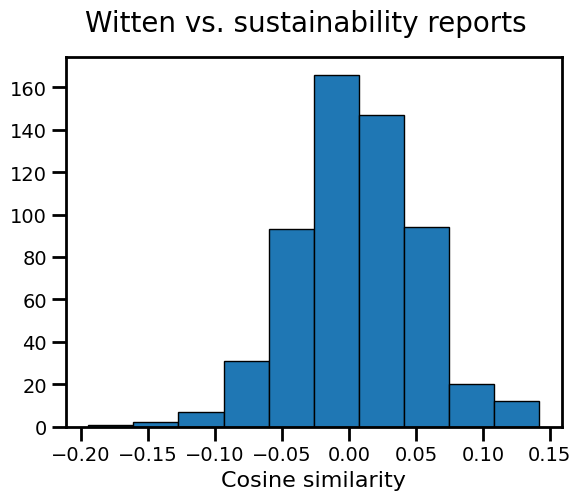

In [29]:
plt.hist(cos_sims, edgecolor='black')
plt.suptitle('Witten vs. sustainability reports', fontsize=20)
plt.xlabel('Cosine similarity', fontsize=16)
plt.show()

That's much better. 

# PCA

The dimension fo the embedding is the same for all vectors:

In [29]:
len(wittenvec)

768

In [30]:
vecs=np.zeros((len(vecfiles), len(wittenvec)))

In [31]:
for i, vecfile in enumerate(tqdm(vecfiles)):
    vec=np.genfromtxt(VECTOR_FOLDER+vecfile)
    vecs[i]=vec

  0%|          | 0/573 [00:00<?, ?it/s]

## Which percentage?

In [32]:
pca = PCA()
new_vecs=pca.fit_transform(vecs)

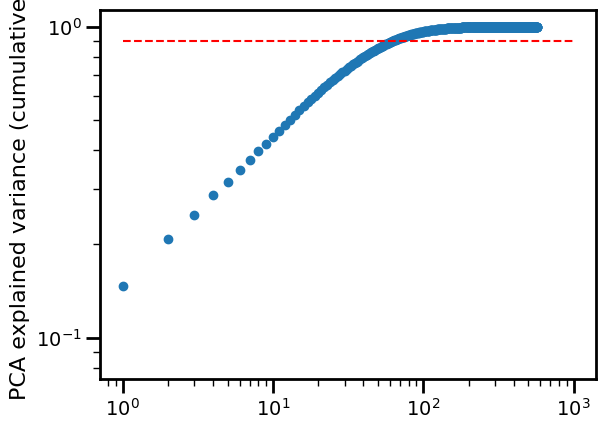

In [33]:
plt.scatter(np.arange(len(vecfiles)), np.cumsum(pca.explained_variance_ratio_))
plt.hlines(0.90, 1, 1000, ls='--', color='red')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('PCA explained variance (cumulative)', fontsize=16)
plt.show()

In [34]:
np.where(np.cumsum(pca.explained_variance_ratio_)<=.90)[0][-1]

63

In [35]:
np.where(np.cumsum(pca.explained_variance_ratio_)<=.95)[0][-1]

87

In [36]:
np.where(np.cumsum(pca.explained_variance_ratio_)<=.99)[0][-1]

160

## Dimensional reduction

In [37]:
pca = PCA(n_components=63)
new_vecs=pca.fit_transform(vecs)

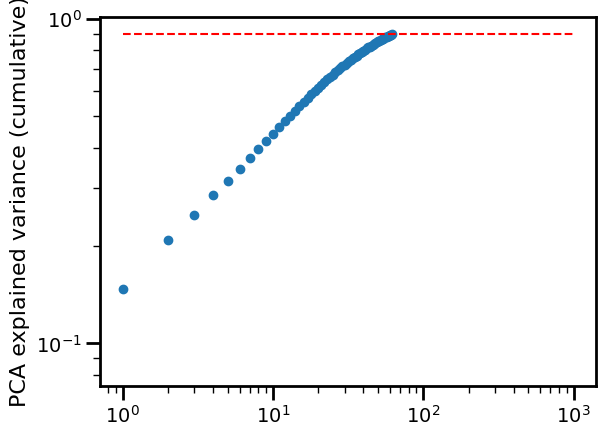

In [38]:
plt.scatter(np.arange(63), np.cumsum(pca.explained_variance_ratio_))
plt.hlines(0.90, 1, 1000, ls='--', color='red')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('PCA explained variance (cumulative)', fontsize=16)
plt.show()

## Check with Witten

In [39]:
wittenvec.T

array([-3.02811189e-02, -3.81932141e-02,  5.04839207e-02, -8.00098124e-03,
       -3.53469865e-02, -3.23630692e-03, -6.81020060e-03, -2.89417768e-02,
        5.92756829e-02,  8.08559115e-03, -1.55386966e-02, -9.66650055e-03,
       -3.56608460e-02, -6.64788847e-03, -4.35948768e-02,  7.00658821e-02,
       -1.15720409e-02,  6.07534971e-03,  6.03255241e-03, -9.20716491e-03,
       -1.40867959e-02, -3.93993677e-02, -3.48379897e-02, -9.90491321e-03,
        2.00452551e-02, -1.42847605e-03,  5.88203656e-02,  2.48458379e-02,
        4.49237034e-02,  3.21563627e-02,  2.96030887e-03, -2.53623230e-02,
       -4.41500462e-02,  1.02410977e-02,  2.29212367e-04, -6.59512065e-02,
       -1.54529956e-02, -1.65040052e-03,  7.72846153e-02,  6.11668911e-02,
       -2.46362986e-02,  5.33290305e-03,  1.44023294e-02,  6.18857648e-02,
       -5.30239550e-02, -9.63267495e-03, -1.90574004e-02,  1.46386031e-02,
       -2.03105476e-02, -4.04475940e-02, -2.31404802e-02, -3.59528446e-02,
        2.79525956e-03, -

In [40]:
new_wittenvec = pca.transform([wittenvec])

In [41]:
pca_cos_sims=np.zeros(len(vecfiles))
for i, vecfile in enumerate(tqdm(vecfiles)):
    cos_sim=float(util.cos_sim(new_wittenvec, new_vecs[i]))
    #print(f'{vecfile:})\tcos={cos_sim:.3f}')
    pca_cos_sims[i]=cos_sim

  0%|          | 0/573 [00:00<?, ?it/s]

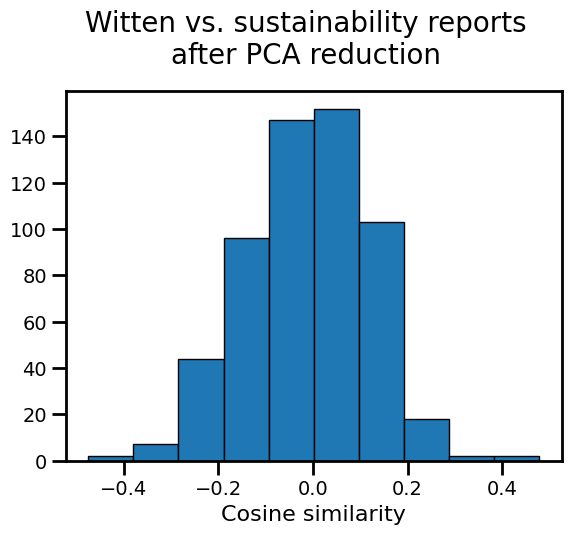

In [42]:
plt.hist(pca_cos_sims, edgecolor='black')
plt.suptitle('Witten vs. sustainability reports\nafter PCA reduction', fontsize=20, y=1.05)
plt.xlabel('Cosine similarity', fontsize=16)
plt.show()

# Post-processing

In [30]:
allvecs=np.zeros((len(vecfiles), len(wittenvec)))

In [31]:
for i, vecfile in enumerate(tqdm(vecfiles)):
    vec=np.genfromtxt(VECTOR_FOLDER+vecfile)
    allvecs[i]=vec

  0%|          | 0/573 [00:00<?, ?it/s]

## All-but-the-top

The sense of the PCA in our context is that there is still a residual bulk of spurious signal carried by the 1st component of the PCA that is uninformative. Therefore, we remove it, once we remove the effect of the mean vector.

In [32]:
no_mean_vecs=allvecs-mean_vec

In [97]:
k = 5
pca = PCA(n_components=k)
pca.fit(no_mean_vecs)
U = pca.components_          # matrice k × d

# Proiezione su subspazio delle prime k PC
no_mean_vecs_proj = no_mean_vecs.dot(U.T).dot(U)   # (n, d)

# Rimozione delle k componenti
no_mean_vecs_debiased = no_mean_vecs - no_mean_vecs_proj

### Check with Witten

In [98]:
new_wittenvec = wittenvec - mean_vec
new_wittenvec-=new_wittenvec.dot(U.T).dot(U)

In [99]:
pca_cos_sims_w=np.zeros(len(vecfiles))
for i, vecfile in enumerate(tqdm(vecfiles)):
    cos_sim=float(util.cos_sim(new_wittenvec, no_mean_vecs_debiased[i]))
    #print(f'{vecfile:})\tcos={cos_sim:.3f}')
    pca_cos_sims_w[i]=cos_sim

  0%|          | 0/573 [00:00<?, ?it/s]

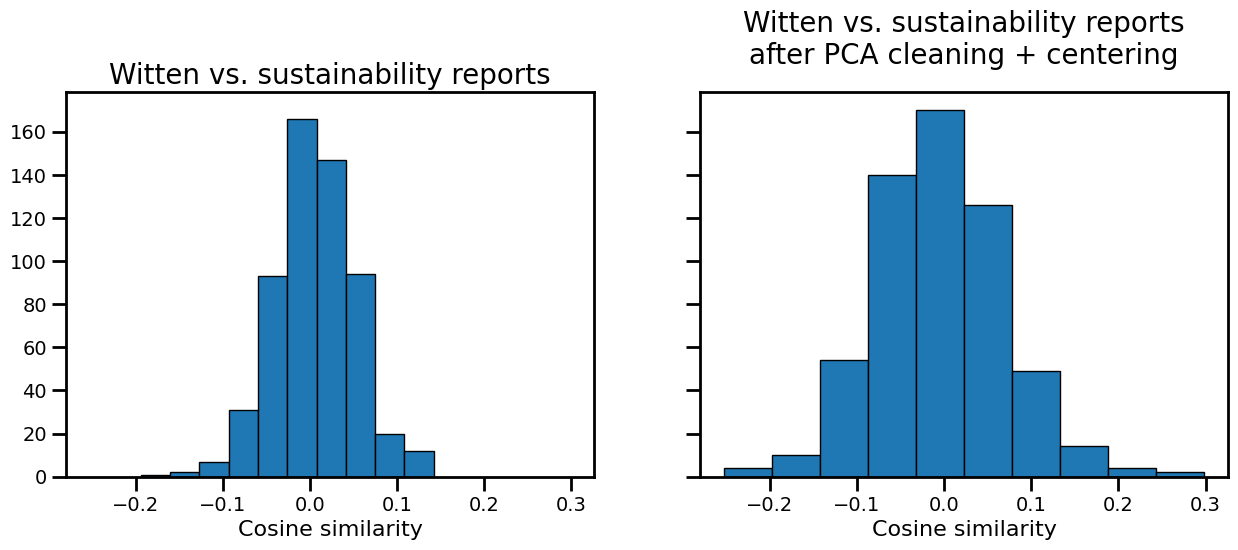

In [100]:
fig, axs=plt.subplots(1,2,sharex=True, sharey=True, figsize=(15, 5))

axs[0].hist(cos_sims, edgecolor='black')
axs[0].set_title('Witten vs. sustainability reports', fontsize=20)
axs[0].set_xlabel('Cosine similarity', fontsize=16)


axs[1].hist(pca_cos_sims_w, edgecolor='black')
axs[1].set_title('Witten vs. sustainability reports\nafter PCA cleaning + centering', fontsize=20, y=1.05)
axs[1].set_xlabel('Cosine similarity', fontsize=16)
plt.show()

In [101]:
np.mean(cos_sims), np.std(cos_sims)

(0.005177349204742545, 0.04661277849958448)

In [102]:
np.mean(pca_cos_sims_w), np.std(pca_cos_sims_w)

(-0.00464757093594449, 0.07456270635244044)

## RobustScaler

It should rescale more efficiently, proper considering outliers.

In [103]:
rs = RobustScaler()
rs.fit(allvecs)

rs_allvecs=rs.transform(allvecs)

### Check with Witten

In [104]:
rs_wittenvec=rs.transform([wittenvec])

In [105]:
rs_cos_sims_w=np.zeros(len(vecfiles))
for i, vecfile in enumerate(tqdm(vecfiles)):
    cos_sim=float(util.cos_sim(rs_wittenvec, rs_allvecs[i]))
    #print(f'{vecfile:})\tcos={cos_sim:.3f}')
    rs_cos_sims_w[i]=cos_sim

  0%|          | 0/573 [00:00<?, ?it/s]

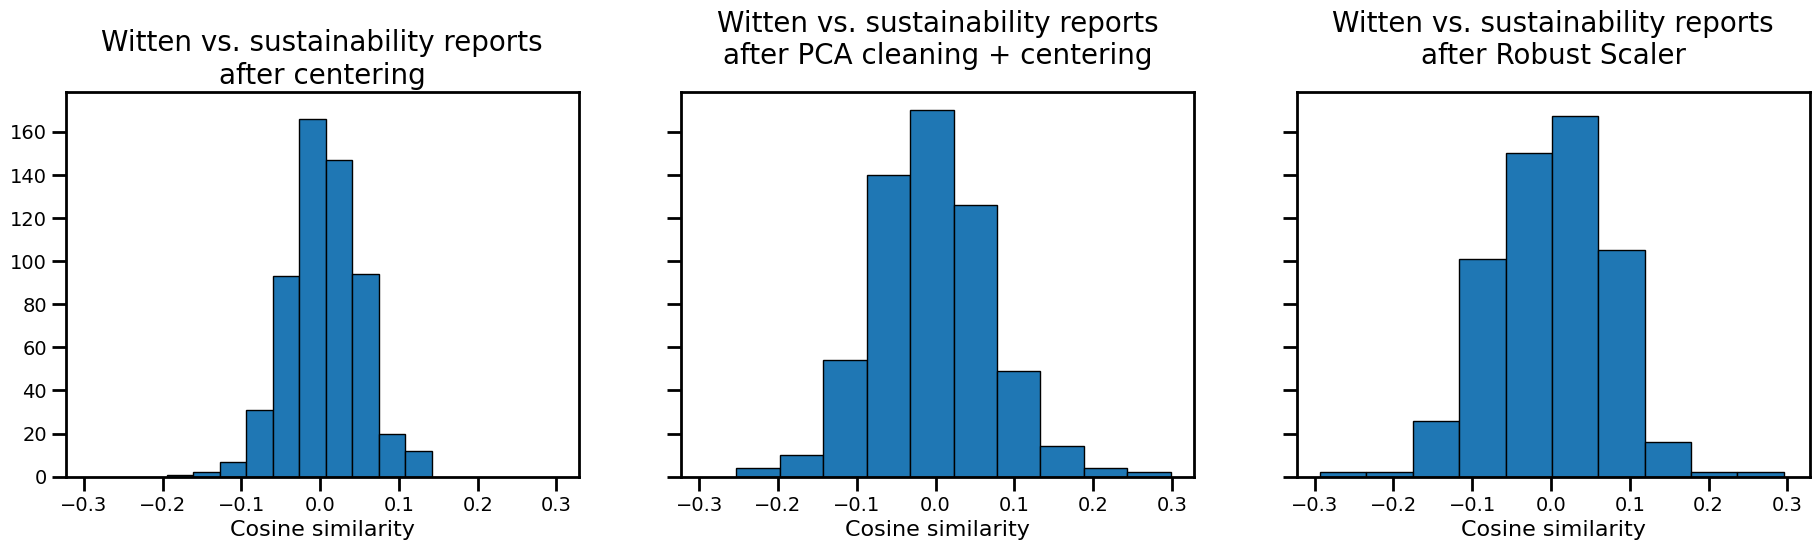

In [106]:
fig, axs=plt.subplots(1,3,sharex=True, sharey=True, figsize=(22.5, 5))

axs[0].hist(cos_sims, edgecolor='black')
axs[0].set_title('Witten vs. sustainability reports\nafter centering', fontsize=20)
axs[0].set_xlabel('Cosine similarity', fontsize=16)

axs[1].hist(pca_cos_sims_w, edgecolor='black')
axs[1].set_title('Witten vs. sustainability reports\nafter PCA cleaning + centering', fontsize=20, y=1.05)
axs[1].set_xlabel('Cosine similarity', fontsize=16)

axs[2].hist(rs_cos_sims_w, edgecolor='black')
axs[2].set_title('Witten vs. sustainability reports\nafter Robust Scaler', fontsize=20, y=1.05)
axs[2].set_xlabel('Cosine similarity', fontsize=16)
plt.show()

In [107]:
np.mean(cos_sims), np.std(cos_sims)

(0.005177349204742545, 0.04661277849958448)

In [108]:
np.mean(pca_cos_sims_w), np.std(pca_cos_sims_w)

(-0.00464757093594449, 0.07456270635244044)

In [109]:
np.mean(rs_cos_sims_w), np.std(rs_cos_sims_w)

(0.0007621024673115121, 0.07322976536378889)

## Check the internal similarity

In [110]:
def abtt(vec, mean_vec, U):
    no_mean_vec=bench_vec-mean_vec
    # Proiezione su subspazio delle prime k PC
    no_mean_vec_proj = no_mean_vec.dot(U.T).dot(U)   # (n, d)

    # Rimozione delle k componenti
    return no_mean_vec - no_mean_vec_proj

In [111]:
nmv_cs=[]
abtt_cs=[]
rs_cs=[]
for i in trange(len(no_mean_vecs)):
    for j in range(i+1, len(no_mean_vecs)):
        nmv_cs.append(float(util.cos_sim(no_mean_vecs[i], no_mean_vecs[j])))
        abtt_cs.append(float(util.cos_sim(no_mean_vecs_debiased[i], no_mean_vecs_debiased[j])))
        rs_cs.append(float(util.cos_sim(rs_allvecs[i], rs_allvecs[j])))
            

  0%|          | 0/573 [00:00<?, ?it/s]

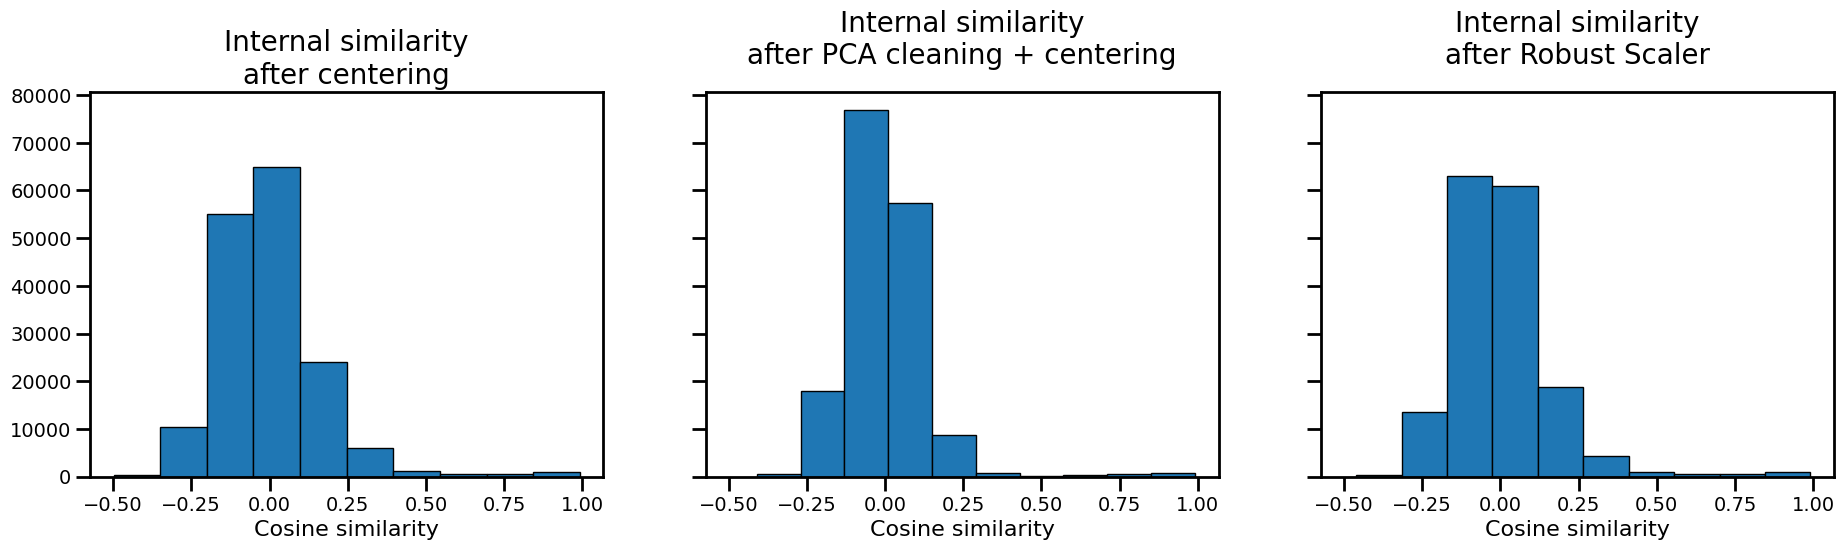

In [112]:
fig, axs=plt.subplots(1,3,sharex=True, sharey=True, figsize=(22.5, 5))

axs[0].hist(nmv_cs, edgecolor='black')
axs[0].set_title('Internal similarity\nafter centering', fontsize=20)
axs[0].set_xlabel('Cosine similarity', fontsize=16)

axs[1].hist(abtt_cs, edgecolor='black')
axs[1].set_title('Internal similarity\nafter PCA cleaning + centering', fontsize=20, y=1.05)
axs[1].set_xlabel('Cosine similarity', fontsize=16)

axs[2].hist(rs_cs, edgecolor='black')
axs[2].set_title('Internal similarity\nafter Robust Scaler', fontsize=20, y=1.05)
axs[2].set_xlabel('Cosine similarity', fontsize=16)
plt.show()

In [113]:
np.mean(nmv_cs), np.std(nmv_cs)

(-0.0013297543442454167, 0.16346839178999395)

In [114]:
np.mean(abtt_cs), np.std(abtt_cs)

(-0.0011573435271688122, 0.13018347989841272)

In [115]:
np.mean(rs_cs), np.std(rs_cs)

(0.0015516712885934964, 0.1558217895637591)

They are practically equivalent.

## Save transformed vectors

### Reports

In [116]:
for i, vecfile in enumerate(tqdm(vecfiles)):
    np.savetxt(PCA_CENTR_VECTOR_FOLDER+vecfile, no_mean_vecs_debiased[i])

  0%|          | 0/573 [00:00<?, ?it/s]

### New Benchmarks

In [117]:
benchmark_files=[file for file in os.listdir(BENCHMARK_FOLDER) if file.endswith('.txt') and (file.startswith('Goal') or file.startswith('Witten'))]
benchmark_files.sort()
for file in tqdm(benchmark_files):
    bench_vec=np.genfromtxt(BENCHMARK_FOLDER+file)
    new_bench_vec=abtt(bench_vec, mean_vec, U)
    np.savetxt(PCA_CENTR_VECTOR_FOLDER+file, new_bench_vec)

  0%|          | 0/19 [00:00<?, ?it/s]

In [118]:
for goalvecfile in benchmark_files:
    if goalvecfile.startswith('Goal'):
        num=goalvecfile.split('_')[0].split('-')[1]
        if len(num)==1:
            new_name='Goal-'+num.zfill(2)+'-Fast-Facts.txt'
            os.rename(PCA_CENTR_VECTOR_FOLDER+goalvecfile, PCA_CENTR_VECTOR_FOLDER+new_name)

In [119]:
goalfiles=[file for file in os.listdir(PCA_CENTR_VECTOR_FOLDER) if file.endswith('.txt') and file.startswith('Goal')]
goalfiles.sort()
goalfiles

['Goal-01-Fast-Facts.txt',
 'Goal-02-Fast-Facts.txt',
 'Goal-03-Fast-Facts.txt',
 'Goal-04-Fast-Facts.txt',
 'Goal-05-Fast-Facts.txt',
 'Goal-06-Fast-Facts.txt',
 'Goal-07-Fast-Facts.txt',
 'Goal-08-Fast-Facts.txt',
 'Goal-09-Fast-Facts.txt',
 'Goal-10-Fast-Facts.txt',
 'Goal-11_Fast-Facts.txt',
 'Goal-12_Fast-Facts.txt',
 'Goal-13_Fast-Facts.txt',
 'Goal-14_Fast-Facts.txt',
 'Goal-15-Fast-Facts.txt',
 'Goal-16-Fast-Facts.txt',
 'Goal-17-Fast-Facts.txt',
 'Goal-Fast-Facts.txt']

## Check with SDGs

### Goals' vectors

In [120]:
goalvecfiles=[file for file in os.listdir(PCA_CENTR_VECTOR_FOLDER) if file.startswith('Goal') and file.endswith('.txt')]

In [121]:
goalvecfiles.sort()

In [122]:
goalvecfiles

['Goal-01-Fast-Facts.txt',
 'Goal-02-Fast-Facts.txt',
 'Goal-03-Fast-Facts.txt',
 'Goal-04-Fast-Facts.txt',
 'Goal-05-Fast-Facts.txt',
 'Goal-06-Fast-Facts.txt',
 'Goal-07-Fast-Facts.txt',
 'Goal-08-Fast-Facts.txt',
 'Goal-09-Fast-Facts.txt',
 'Goal-10-Fast-Facts.txt',
 'Goal-11_Fast-Facts.txt',
 'Goal-12_Fast-Facts.txt',
 'Goal-13_Fast-Facts.txt',
 'Goal-14_Fast-Facts.txt',
 'Goal-15-Fast-Facts.txt',
 'Goal-16-Fast-Facts.txt',
 'Goal-17-Fast-Facts.txt',
 'Goal-Fast-Facts.txt']

In [123]:
goalvecs=[np.genfromtxt(PCA_CENTR_VECTOR_FOLDER+goalvecfile) for goalvecfile in goalvecfiles]

### Cosine similarity

In [124]:
pca_cos_sims=np.zeros(len(vecfiles))
for i, vecfile in enumerate(tqdm(vecfiles)):
    cos_sim=float(util.cos_sim(goalvecs[-1], no_mean_vecs_debiased[i]))
    #print(f'{vecfile:})\tcos={cos_sim:.3f}')
    pca_cos_sims[i]=cos_sim

  0%|          | 0/573 [00:00<?, ?it/s]

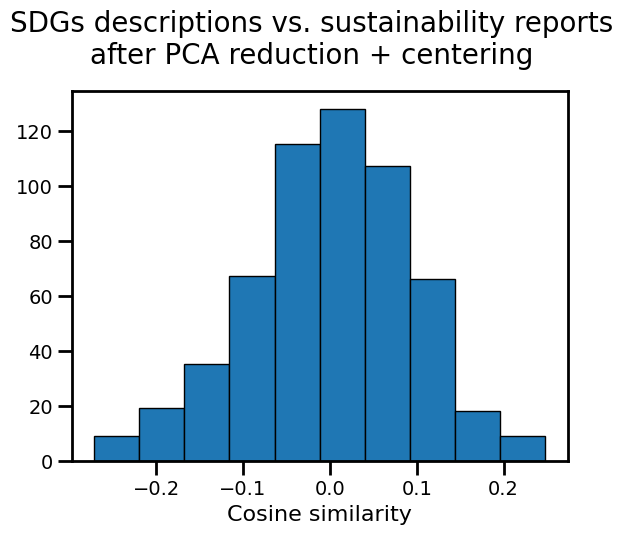

In [125]:
plt.hist(pca_cos_sims, edgecolor='black')
plt.suptitle('SDGs descriptions vs. sustainability reports\nafter PCA reduction + centering', fontsize=20, y=1.05)
plt.xlabel('Cosine similarity', fontsize=16)
plt.show()

In [126]:
np.mean(pca_cos_sims), np.std(pca_cos_sims)

(0.0018652504353695199, 0.09358104103366179)

In [127]:
pca_cos_sims=[]
for i in trange(len(goalvecs)):
    for j in range(i+1, len(goalvecs)):
        cos_sim=float(util.cos_sim(goalvecs[i], goalvecs[j]))
        pca_cos_sims.append(cos_sim)

  0%|          | 0/18 [00:00<?, ?it/s]

In [128]:
pca_cos_sims

[0.6532700681225357,
 0.5283298694735945,
 0.5502240282656485,
 0.4290835562895118,
 0.4952159668776004,
 0.3741369913983052,
 0.5212380582826026,
 0.4157823566698699,
 0.6693101123591018,
 0.45106256482645163,
 0.26386499300315736,
 0.4997294137794311,
 0.3558096311103557,
 0.45889080462804077,
 0.49246162673123783,
 0.4464941861735324,
 0.7329832031206364,
 0.5086438547701004,
 0.5272907638312063,
 0.40278576822746337,
 0.47655136056169733,
 0.4610472729537488,
 0.46672365680107036,
 0.39116799392928236,
 0.5828065619543339,
 0.48195562004869547,
 0.40172593622839803,
 0.46616420066761544,
 0.3744815974427781,
 0.4525677630299402,
 0.5088286665293309,
 0.4285053427333051,
 0.7099720987693459,
 0.5219556031009718,
 0.5204485594409802,
 0.5894875056598989,
 0.431352172360983,
 0.4874620126777297,
 0.37644637650820467,
 0.5821748270377578,
 0.4692628077698827,
 0.21183436328947858,
 0.39591340978667394,
 0.27488015862643467,
 0.39309507925360826,
 0.5143505405176005,
 0.4165980138765562

## Wikipedia benchmark

In [129]:
wikipedia_files=[file for file in os.listdir(WIKI_FOLDER) if file.endswith('.txt') and file.startswith('wikipedia')]
for file in tqdm(wikipedia_files):
    bench_vec=np.genfromtxt(WIKI_FOLDER+file)
    new_bench_vec=abtt(bench_vec, mean_vec, U)
    np.savetxt(PCA_CENTR_VECTOR_FOLDER+file, new_bench_vec)

  0%|          | 0/4001 [00:00<?, ?it/s]

In [131]:
len(new_bench_vec)

768